In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math
# from numba import njit

In [2]:
WN = np.loadtxt('W_avg.csv') ### not symmetric!! travel out is added up tp zero, travel in is not add to zero
Cave = np.loadtxt('Cave.csv')
pop = np.loadtxt('pop_new.csv')

In [28]:
num_fips = len(pop)
T = 60
num_ens = 300
Z = 3 # latent period
Zb = 1 # scale parameter for Z
D = 5 # infectious period
Db = 1 # scale parameter for b
alpha = 0.1 # reporting rate 10%
# seeding
l0 = 1859-1 # start with New York County NY in python -1, in matlab is 1859
i0 = 100 ## the starting t=0, in matlab it is 1
initials = (l0,i0)
R0=2.5

In [29]:
def state_M(M,states):
    N = M.shape[0]
    state_outflow = (np.sum(M,axis=0)-np.diag(M))*states  ### sum up the prob and then sum the value
    state_in_w = np.zeros_like(M)
    for j in range(N):
        state_in_w[:,j] = M[:,j]*(states[j])
    np.fill_diagonal(state_in_w,0)
    state_inflow = np.sum(state_in_w,axis=1)
    return state_outflow, state_inflow

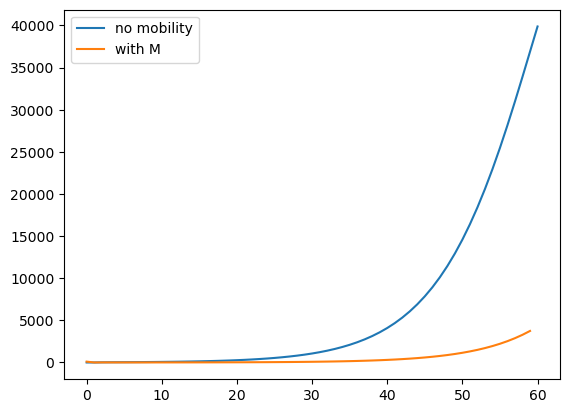

In [124]:
plt.plot(results[4],label='no mobility')
plt.plot(NewInf[1858],label='with M')
plt.legend()

In [30]:
def SEIR_M(params, pop, initials, M, T, dt=1):
    """
    SEIR model with migration
    :param params: list of parameters [R0, Z, D]
    :param pop: population size of each location
    :param initials: list of initial values [start_pos, E0]
    :param M: migration matrix
    :param T: number of time steps
    :param dt: time step size
    """
    # Parameters
    R0 = params[0]
    Z = params[1]
    D = params[2]

    start_pos, E0 = initials
    N = len(pop)  # number of locations
    # initialize
    NewInf = np.zeros((N, T))
    NewInf[start_pos, 0] = E0
    x = np.zeros((N, 4))  # S, E, I for three populations
    x[:,0] = pop
    x[start_pos, 0] = pop[start_pos] - E0  # Susceptibles
    x[start_pos, 1] = E0  # Exposed


    for t in range(1, 60):  # Starting from 1 because we already initialized NewInf at time 0
#         print(t)
        for _ in range(int(1 / dt)): 
            S = x[:, 0]
            E = x[:, 1]
            I = x[:, 2]
            R = x[:, 3]
    #             x_new = x.copy()
            ds = - R0 / D * S * I / pop 
    #             NewInf[:, t] += infection
            NewInf[:,t] = - ds #x[:, 1]/Z #ds
            de =  R0 / D * S * I / pop - E/Z
            di =  E/Z - I/D
            dr = I/D
            S += ds*dt 
            E += de*dt 
            I += di*dt 
            R += dr*dt
            ## then travel
            s_moveout,s_movein = state_M(M,S)
            e_moveout,e_movein = state_M(M,E)
            i_moveout,i_movein = state_M(M,I)
            r_moveout,r_movein = state_M(M,R)
            S += (- s_moveout + s_movein)*dt 
            E += (- e_moveout + e_movein)*dt 
            I += (- i_moveout + i_movein)*dt 
            R += (- r_moveout + r_movein)*dt 
    return x, NewInf

In [7]:
%run ../codes/SEIR_M.py

In [26]:
# S,E,I,NewInf = SEIR_M(params=[2.5,3,5], pop=pop, initials=[1859-1,100], M=WN, T=60, dt=1)
X, NewInf = SEIR_M(params=[2.5,3,5], pop=pop, initials=[1859-1,100], M=WN, T=60, dt=0.01)

KeyboardInterrupt: 

In [23]:
np.savetxt('metapop_R025.csv',NewInf)

In [20]:
infec_perpop = NewInf/pop[:,None]*100000

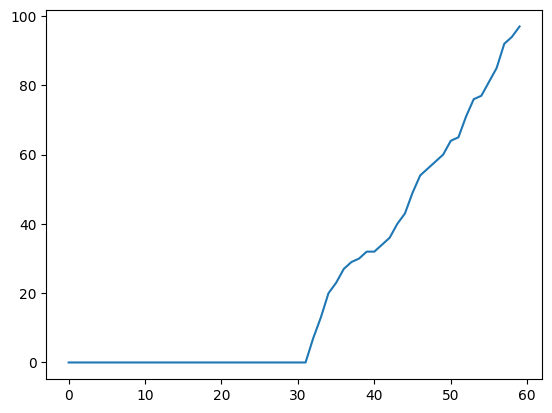

In [21]:
plt.figure(figsize=)
plt.plot(np.sum(infec_perpop>10,axis=0))

In [22]:
np.sum(infec_perpop>10,axis=0)[-1]

97

In [24]:
X.shape

(3142, 3)